In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
import TSManager as ts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

from CorrScreen import CorrScreenPredictor
import TSManager as ts
from TradingBot import TradingBot

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
#reload(ts)
#mgr = ts.TSManager()
#mgr.load()
#df = mgr.data
df = pd.read_pickle('train_prepared.pkl')
df.head()

,IC,VRP,BDI,SI,DP,PE,BM,CAPE,PCAPrice,BY,...,TERM,CAY,SIM,NOS,CPI,PCR,MA,OIL,SPX,RF
AsOfDate,,,,,,,,,,,,,,,,,,,,,
1990-06-08,NaN,0.737088,-0.152808,NaN,0.063979,7.524271,NaN,8.978524,3.616905,1.007418,...,0.50,-0.013576,0.715385,0.016941,0.046737,-1.622923,1.0,NaN,-0.012302,NaN
1990-06-11,NaN,-0.853208,-0.163823,NaN,0.063463,7.597792,NaN,9.051612,3.583706,1.009642,...,0.49,-0.013576,0.707692,0.016941,0.046737,-1.615366,1.0,NaN,0.008107,NaN
1990-06-12,NaN,-0.057387,-0.171766,NaN,0.062662,7.699009,NaN,9.167251,3.532720,1.009580,...,0.49,-0.013576,0.700000,0.016941,0.046737,-1.618868,1.0,NaN,0.012695,NaN
1990-06-13,NaN,1.332508,-0.180577,NaN,0.062894,7.674771,NaN,9.133460,3.547245,1.000056,...,0.47,-0.013576,0.692308,0.016941,0.046737,-1.625316,1.0,NaN,-0.003693,NaN
1990-06-14,NaN,1.204540,-0.189466,NaN,0.063241,7.636994,NaN,9.083400,3.569002,0.997689,...,0.46,-0.013576,0.684615,0.016941,0.046737,-1.620454,1.0,NaN,-0.005496,NaN


In [3]:
# constructing the target label
df['spx_tp130'] = df['SPX'].rolling(130).sum().shift(-129)
df = df.dropna(subset=['spx_tp130'])

In [4]:
# normalization pipeline
scaler = StandardScaler()
si = SimpleImputer(strategy='median')
pipe = make_pipeline(scaler, si)

In [5]:
cols_to_pipe = [c for c in df.columns if c not in ['SPX','RF','spx_tp130']]
df[cols_to_pipe] = pipe.fit_transform(df[cols_to_pipe])

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


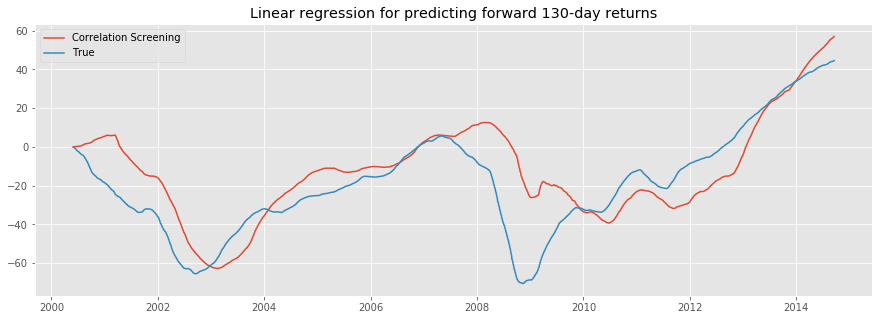

In [6]:
# test predictions

nbp = 180 # number of periods to be used
CSP = CorrScreenPredictor(df)
CSP.plot_predict(nbp)

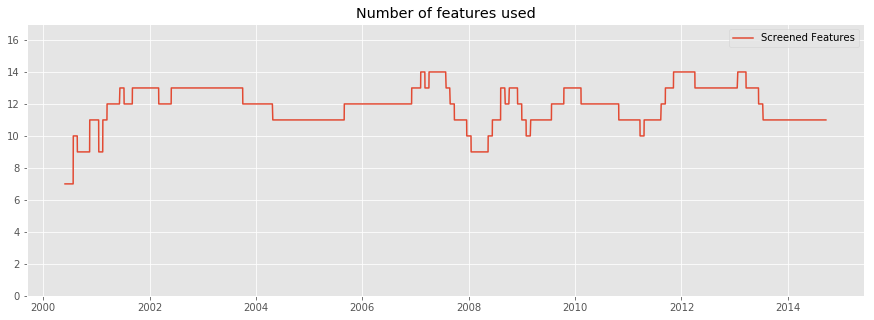

In [7]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

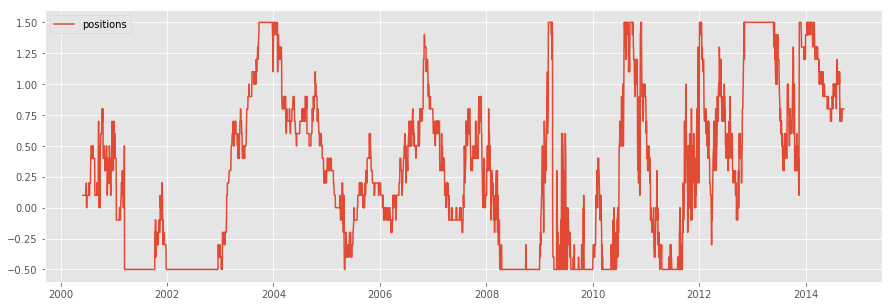

In [8]:
# plot positions

tb = TradingBot(df)

pos = tb.CS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

------------------------------
number of years    : 14.29
annual return SPX  : 3.21 %
annual return strat: 4.1 %
------------------------------


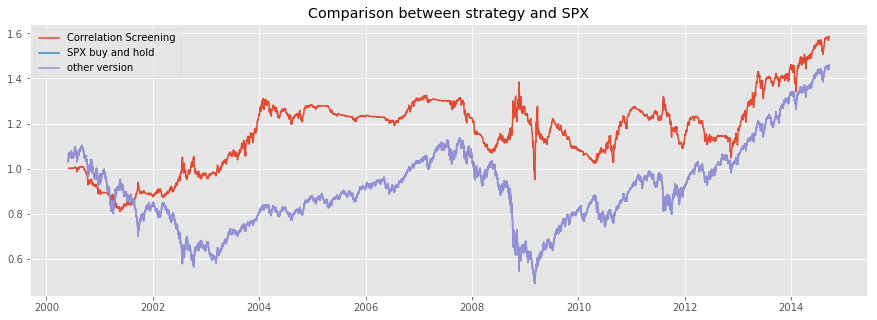

In [9]:
# plot wealth

tb.plot_wealth_CS(nbp)